# Reinforcement Learning (DQN)

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

%matplotlib inline

import gym.wrappers

env = gym.make('BreakoutDeterministic-v4').unwrapped
#env = gym.make('BreakoutDeterministic-v4')

#env = gym.wrappers.Monitor(env, directory="videos", force=True)

# set up matplotlib
#is_ipython = 'inline' in matplotlib.get_backend()
#if is_ipython:
#    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay Memory

In [2]:
class SumTree(object):
    """
    This SumTree code is modified version of Morvan Zhou: 
    https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5.2_Prioritized_Replay_DQN/RL_brain.py
    """
    data_pointer = 0
    
    """
    Here we initialize the tree with all nodes = 0, and initialize the data with all values = 0
    """
    def __init__(self, capacity):
        self.capacity = capacity # Number of leaf nodes (final nodes) that contains experiences
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema above
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        """ tree:
            0
           / \
          0   0
         / \ / \
        0  0 0  0  [Size: capacity] it's at this line that there is the priorities score (aka pi)
        """
        
        # Contains the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)
    
    
    """
    Here we add our priority score in the sumtree leaf and add the experience in data
    """
    def add(self, priority, data):
        # Look at what index we want to put the experience
        tree_index = self.data_pointer + self.capacity - 1
        
        """ tree:
            0
           / \
          0   0
         / \ / \
tree_index  0 0  0  We fill the leaves from left to right
        """
        
        # Update data frame
        self.data[self.data_pointer] = data
        
        # Update the leaf
        self.update (tree_index, priority)
        
        # Add 1 to data_pointer
        self.data_pointer += 1
        
        if self.data_pointer >= self.capacity:  # If we're above the capacity, you go back to first index (we overwrite)
            self.data_pointer = 0
            
    
    """
    Update the leaf priority score and propagate the change through tree
    """
    def update(self, tree_index, priority):
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        
        # then propagate the change through tree
        while np.sum(tree_index) != 0:    # this method is faster than the recursive loop in the reference code
            
            """
            Here we want to access the line above
            THE NUMBERS IN THIS TREE ARE THE INDEXES NOT THE PRIORITY VALUES
            
                0
               / \
              1   2
             / \ / \
            3  4 5  [6] 
            
            If we are in leaf at index 6, we updated the priority score
            We need then to update index 2 node
            So tree_index = (tree_index - 1) // 2
            tree_index = (6-1)//2
            tree_index = 2 (because // round the result)
            """
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
    
    
    """
    Here we get the leaf_index, priority value of that leaf and experience associated with that index
    """
    def get_leaf(self, v):
        """
        Tree structure and array storage:
        Tree index:
             0         -> storing priority sum
            / \
          1     2
         / \   / \
        3   4 5   6    -> storing priority for experiences
        Array type for storing:
        [0,1,2,3,4,5,6]
        """
        parent_index = 0
        
        while True: # the while loop is faster than the method in the reference code
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            
            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            
            else: # downward search, always search for a higher priority node
                
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                    
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index
            
        data_index = leaf_index - self.capacity + 1

        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    @property
    def total_priority(self):
        return self.tree[0] # Returns the root node


Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory_OLD(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class ReplayMemory(object):  # stored as ( s, a, r, s_ ) in SumTree
    """
    This SumTree code is modified version and the original code is from:
    https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py
    """
    PER_e = 0.01  # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
    PER_a = 1.  # Hyperparameter that we use to make a tradeoff between taking only exp with high priority and sampling randomly
    PER_b = 0.4  # importance-sampling, from initial value increasing to 1
    
    PER_b_increment_per_sampling = 0.001
    
    absolute_error_upper = 1.  # clipped abs error

    def __init__(self, capacity):
        # Making the tree 
        """
        Remember that our tree is composed of a sum tree that contains the priority scores at his leaf
        And also a data array
        We don't use deque because it means that at each timestep our experiences change index by one.
        We prefer to use a simple array and to overwrite when the memory is full.
        """
        self.tree = SumTree(capacity)
        
    """
    Store a new experience in our tree
    Each new experience have a score of max_prority (it will be then improved when we use this exp to train our DDQN)
    """
    def store(self, experience):
        # Find the max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        
        # If the max priority = 0 we can't put priority = 0 since this exp will never have a chance to be selected
        # So we use a minimum priority
        if max_priority == 0:
            max_priority = self.absolute_error_upper
        
        self.tree.add(max_priority, experience)   # set the max p for new p

        
    """
    - First, to sample a minibatch of k size, the range [0, priority_total] is / into k ranges.
    - Then a value is uniformly sampled from each range
    - We search in the sumtree, the experience where priority score correspond to sample values are retrieved from.
    - Then, we calculate IS weights for each minibatch element
    """
    def sample(self, n):
        # Create a sample array that will contains the minibatch
        memory_b = []
        
        b_idx, b_ISWeights = np.empty((n,), dtype=np.int32), np.empty((n, 1), dtype=np.float32)
        
        # Calculate the priority segment
        # Here, as explained in the paper, we divide the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / n       # priority segment
    
        # Here we increasing the PER_b each time we sample a new minibatch
        self.PER_b = np.min([1., self.PER_b + self.PER_b_increment_per_sampling])  # max = 1
        
        # Calculating the max_weight
        p_min = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_priority
        max_weight = (p_min * n) ** (-self.PER_b)
        
        for i in range(n):
            """
            A value is uniformly sample from each range
            """
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)
            
            """
            Experience that correspond to each value is retrieved
            """
            index, priority, data = self.tree.get_leaf(value)
            
            #P(j)
            sampling_probabilities = priority / self.tree.total_priority
            
            #  IS = (1/N * 1/P(i))**b /max wi == (N*P(i))**-b  /max wi
            b_ISWeights[i, 0] = np.power(n * sampling_probabilities, -self.PER_b)/ max_weight
                                   
            b_idx[i]= index
            
            experience = [data]
            
            memory_b.append(experience)
        
        return b_idx, memory_b, b_ISWeights
    
    """
    Update the priorities on the tree
    """
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)
            
    def __len__(self):
        return np.sum(self.tree.data != 0)

# Frame Buffer

In [4]:
class FrameBuffer(object):

    def __init__(self, shape, n_frames=4):
        b, c, h, w = shape
        self.capacity = n_frames
        self.framebuffer = np.zeros((b, c * n_frames, h, w), 'float32')

    def push(self, state):
        """Saves a transition."""
        self.framebuffer = np.roll(self.framebuffer, -1, axis=1)
        self.framebuffer[0, 3] = state
        
        if self.__len__() < self.capacity:
            self.framebuffer = np.repeat(self.framebuffer[:,3,:,:], [self.capacity], axis=0)
            self.framebuffer = np.expand_dims(self.framebuffer, axis=0)

    def pull(self):

        if self.__len__()==0: raise Exception('Framebuffer empty.')

        return torch.tensor(self.framebuffer, device=device)

    def __len__(self):
        return np.sum(np.sum(self.framebuffer, axis=(2,3)) > 0)

# Framebuffer Test

frame_buffer = FrameBuffer(shape=(screen_batch, screen_channel, screen_height, screen_width))
env.reset()
s = get_screen()
frame_buffer.push(s)
state = frame_buffer.pull()


plt.subplot(1, 4, 1)
plt.imshow(state[0,0,:,:].cpu().numpy(), cmap='gray')

plt.subplot(1, 4, 2)
plt.imshow(state[0,1,:,:].cpu().numpy(), cmap='gray')

plt.subplot(1, 4, 3)
plt.imshow(state[0,2,:,:].cpu().numpy(), cmap='gray')

plt.subplot(1, 4, 4)
plt.imshow(state[0,3,:,:].cpu().numpy(), cmap='gray')


for _ in range(4):
    action = select_action(state)      
    next_s, reward, done, _ = env.step(3)     
    s = get_screen()
    frame_buffer.push(s)
    state = frame_buffer.pull()
    print(reward)

# Q-network

In [5]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


# Input extraction

In [6]:
from skimage.transform import resize

#resize = T.Compose([T.ToPILImage(),T.Resize(64, interpolation=Image.CUBIC)])

IMG_TARGET_SIZE = (64, 64, 1)

def get_screen():
    
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array')
    
    screen_height, screen_width, _ = screen.shape
    
    screen = screen[int(screen_height*0.28):int(screen_height * 0.92), :]
    
    view_width = int(screen_width * 0.95)

    slice_range = slice(screen_width - view_width, view_width)

    # Strip off the edges
    screen = screen[:, slice_range, :]
    
    screen = screen.mean(2, keepdims=True) # 3 channel to 1
    
    screen = resize(screen, IMG_TARGET_SIZE) / 255.
    
    screen = screen.transpose((2, 0, 1))
    
    screen = np.expand_dims(screen, axis=0)

    return screen

#env.reset()
#plt.figure()
#plt.imshow(get_screen()[0,0,:,:], cmap='gray')
#plt.title('Example extracted screen')
#plt.show()

# Training

In [7]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 0.0001
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
screen_batch, screen_channel, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

#optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-4)
optimizer = optim.Adam(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    #eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done * EPS_DECAY)
    steps_done += 1
        
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_rewards = []
episode_loss = []


def plot_rewards():
    
    plt.rcParams["figure.figsize"] = [15, 15]
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    loss_t = torch.tensor(episode_loss, dtype=torch.float)
    plt.subplot(3, 1, 1)
    plt.title('Training...')
    plt.ylabel('Rewards')
    plt.plot(rewards_t.numpy())
    plt.subplot(3, 1, 2)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.plot(loss_t.numpy())
    plt.show()
    
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.subplot(3, 1, 3)
        plt.title('Average Rewards')
        plt.xlabel('# Rewards')
        plt.ylabel('Avg.')
        plt.plot(means.numpy())

    #plt.pause(1)  # pause a bit so that plots are updated
    
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


# Training loop

In [8]:
def optimize_model():

    if len(memory) < memory.tree.capacity:
        return
    
    tree_idx, batch, ISWeights_mb = memory.sample(BATCH_SIZE)
      
    state_batch = [each[0][0] for each in batch]
    action_batch = [each[0][1] for each in batch]
    reward_batch = [each[0][2] for each in batch]
    next_states_batch = [each[0][3] for each in batch]
    dones_batch = [each[0][4] for each in batch]
    
    state_batch = torch.cat([s for s in state_batch if s is not None])
    action_batch = torch.cat(action_batch)
    reward_batch = torch.cat(reward_batch).unsqueeze(1)
    next_states_batch = torch.cat([s for s in next_states_batch if s is not None])
    is_not_done = (1 - torch.tensor(dones_batch, dtype=torch.float)).unsqueeze(1).to(device)
                
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch) * is_not_done

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    action_next_state = torch.zeros(BATCH_SIZE, device=device)
    
    action_next_state = policy_net(next_states_batch).argmax(1).unsqueeze(1)
    
    next_state_values = target_net(next_states_batch).gather(1, action_next_state)
    
    # Compute the expected Q values
    expected_state_action_values = reward_batch + (next_state_values * GAMMA)

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    
    # Optimize the model
    optimizer.zero_grad()
    
    loss.backward()
    
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    
    prios = (state_action_values - expected_state_action_values).cpu().detach().numpy().squeeze()
    
    memory.batch_update(tree_idx, prios)
    
    optimizer.step()
    
    return loss


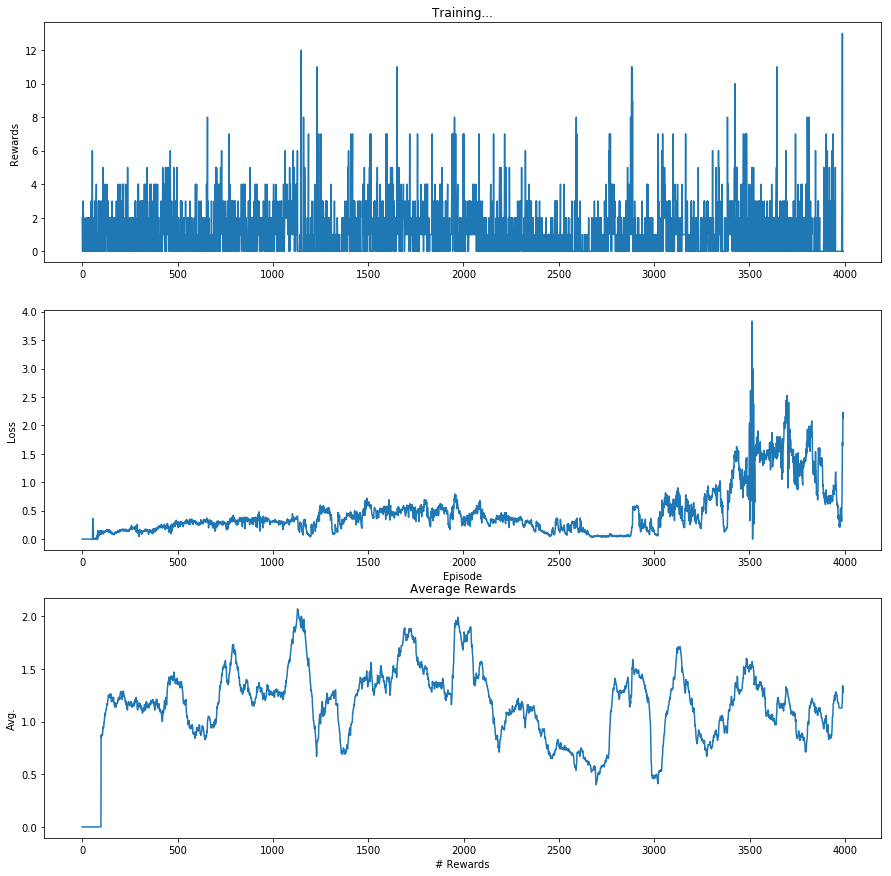

KeyboardInterrupt: 

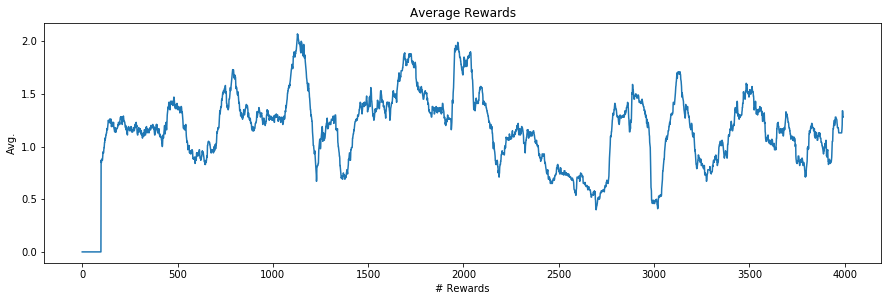

In [9]:
from IPython.display import clear_output

num_episodes = 100000
n_steps = 10000

for i_episode in range(num_episodes):
    
    # Initialize the environment and state
    env.reset()
    reward_list = []
    total_reward = 0

    frame_buffer = FrameBuffer(shape=(screen_batch, screen_channel, screen_height, screen_width))
    s = get_screen()

    frame_buffer.push(s)
    state = frame_buffer.pull()
    
    for t in range(n_steps):
        
        # Select and perform an action
        action = select_action(state)
        
        _, reward, done, _ = env.step(action.item())

        # Sum rewards
        reward = torch.tensor([reward], device=device)
        total_reward += reward
        
        # Get next state with frame buffer
        next_s = get_screen()
        frame_buffer.push(next_s)
        next_state = frame_buffer.pull()
        
        # Store the transition in memory (for Replay)
        experience = state, action, reward, next_state, done

        memory.store(experience)
        
        # Perform one step of the optimization (on the target network)
        loss = optimize_model()
        
        if done:
            episode_rewards.append(total_reward)
            episode_loss.append(loss if loss else 0)
            clear_output(True)
            plot_rewards()
            break
        else:
            state = next_state
            
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
    # Save model
    if i_episode % (TARGET_UPDATE * 5) == 0:
        torch.save(target_net.state_dict(), 'model/target_net_state_dict.pt')

print('Complete')
#env.render()
env.close()